Last Major Update: January 24, 2017

By Daniel Seita (with substantial help from Xinlei Pan and John Canny)

# Analyzing the Logistic Regression Experiment

Let's use this notebook for all the figures and analysis relating to the logistic regression experiment in our paper.

**Naming**:

- Our method is often named as "Our Method" or simply "Ours"
- Korattikara's 2014 ICML paper on the sequential t-test method is sometimes called "Cutting the MH Budget" or "Austerity MH".
- Bardenet's 2014 ICML paper is sometimes called "Adaptive MH".

**Usage**: This Jupyter Notebook should be inside the directory

`New_MH_Test/code/`

so that it correctly refers to the data that are in the file `output`.

**Parameters**: We ran logistic regression on MNIST-8, with 1s and 7s (i.e. binary classification) with the following parameters:

- Training Data Elements: 450,000 training points.
- Testing Data Elements: 192,000 (approximately). This is probably too much.
- Temperature: 1000
- Number of Samples: 3000
- Starting minibatch size and the amount we increment as needed: 100
- Proposer sigma: 0.05 (i.e. we do a random walk on the matrix 0.05\*I).

Some parameters specific to the competing methods:

- Korattikara epsilon: 0.05
- Bardenet gamma: 2.0
- Bardenet delta: 0.01 (TODO CHECK)
- Bardenet p: 2.0 (TODO CHECK)

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
import h5py
np.set_printoptions(edgeitems=100)


def parse_output(N, mat_name, method):
    """ Returns the (appropriately reshaped) data from our .mat files, to reduce
    a lot of typing.
    
    Args:
        N: The number of sampled \theta values (we started with 3000).
        mat_name: The name of the .mat file which contains the data.
        method: Must be a string, either 'ours', 'kora', or 'bard'.
    
    Returns:
        A tuple of six elements, in order: samples, mb_size, cum_size, ll_test, 
            ll_train, and accuracy, appropriately shaped.
    """
    f = h5py.File(mat_name)
    samples  = np.array(f['samples_'+method])
    mb_size  = np.array(f['mb_size_'+method]).reshape(N,1)
    cum_size = np.array(f['cum_size_'+method]).reshape(N,1)
    ll_test  = np.array(f['ll_test_'+method]).reshape(N,1)
    ll_train = np.array(f['ll_train_'+method]).reshape(N,1)
    accuracy = np.array(f['accuracy_'+method]).reshape(N,1)
    return (samples, mb_size, cum_size, ll_test, ll_train, accuracy)

# Final Results

This next cell will deal with the "final results" or as close as we can get to them. In other words, this cell should generate the figures we will use. The *following* cells will deal with experimentation, etc.

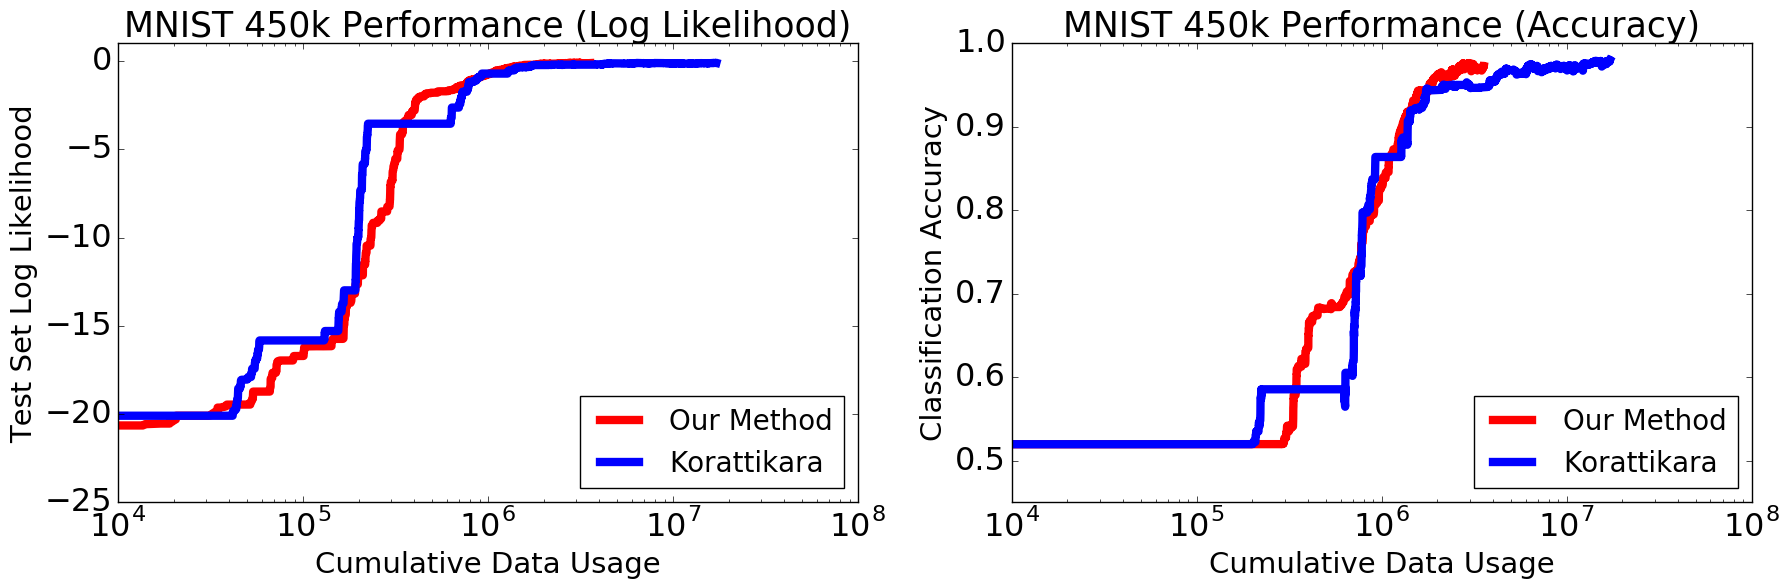

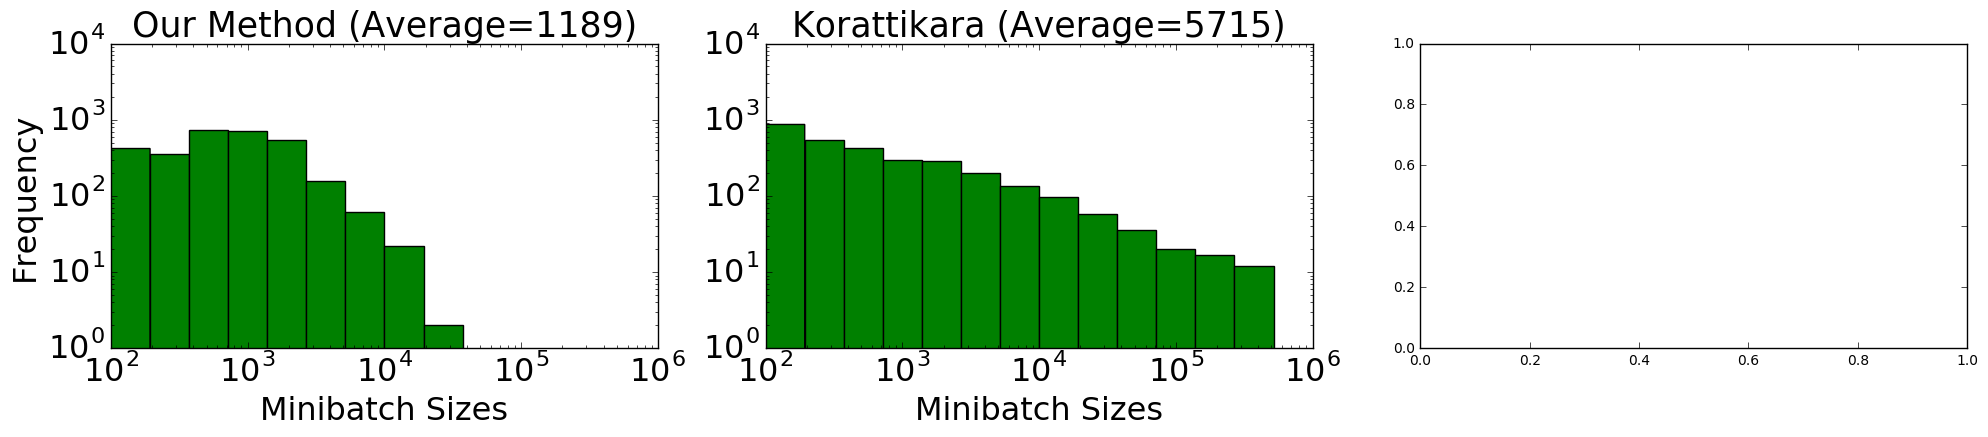

In [2]:
# Some important parameters.
fig_dir_output = 'figures/'
DPI = 300
N = 3000

# Load the data from the matrix files.
samples_ours, mb_size_ours, cum_size_ours, ll_test_ours, ll_train_ours, accuracy_ours = \
    parse_output(N, 'data/testLR_ours_450k_192k_3000_1000.mat', 'ours')
samples_kora, mb_size_kora, cum_size_kora, ll_test_kora, ll_train_kora, accuracy_kora = \
    parse_output(N, 'data/testLR_kora_450k_192k_3000_1000.mat', 'kora')
    
assert samples_ours.shape == (N,784)
assert samples_kora.shape == (N,784)


# First figure, for cumulative data usage.
fig, axarr = plt.subplots(1,2, figsize=(18, 6))
x_label = "Cumulative Data Usage"
title_size = 25
axis_size = 21
tick_size = 23
legend_size = 20
width = 6.0
xlimits = [(10**4), (10**8)]

axarr[0].plot(cum_size_ours, ll_test_ours, 'r', label='Our Method', lw=width)
axarr[0].plot(cum_size_kora, ll_test_kora, 'b', label='Korattikara', lw=width)
#axarr[0].plot(cum_size_bard, ll_test_bard, 'y', label='Bardenet', lw=width)
axarr[0].set_xlim(xlimits)
axarr[0].set_ylim([-25,1])
axarr[0].set_xscale("log")
axarr[0].set_title("MNIST 450k Performance (Log Likelihood)", fontsize=title_size)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel("Test Set Log Likelihood", fontsize=axis_size)
axarr[0].legend(loc="lower right", prop={'size':legend_size})
axarr[0].tick_params(axis='x', labelsize=tick_size)
axarr[0].tick_params(axis='y', labelsize=tick_size)

axarr[1].plot(cum_size_ours, accuracy_ours, 'r', label='Our Method', lw=width)
axarr[1].plot(cum_size_kora, accuracy_kora, 'b', label='Korattikara', lw=width)
#axarr[1].plot(cum_size_bard, accuracy_bard, 'y', label='Bardenet', lw=width)
axarr[1].set_xlim(xlimits)
axarr[1].set_ylim([0.45,1])
axarr[1].set_xscale("log")
axarr[1].set_title("MNIST 450k Performance (Accuracy)", fontsize=title_size)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
axarr[1].set_ylabel("Classification Accuracy", fontsize=axis_size)
axarr[1].legend(loc="lower right", prop={'size':legend_size})
axarr[1].tick_params(axis='x', labelsize=tick_size)
axarr[1].tick_params(axis='y', labelsize=tick_size)

plt.tight_layout()
plt.savefig(fig_dir_output+"logistic_regression_ll_acc_results.png", dpi=DPI)



#  Next, deal with the miniibatch size counts.
fig, axarr = plt.subplots(1,3, figsize=(20, 4.5))
min_x = (10**2)
max_x = (10**6)
min_y = 0
max_y = 10000
yaxis_ticks = [1,10,100,1000,10000]
title_size = 25
axis_size = 23
tick_size = 23
fc = 'green'
x_label = "Minibatch Sizes"
y_label = "Frequency"

axarr[0].set_title("Our Method (Average={})".format(int(np.mean(mb_size_ours))), fontsize=title_size)
axarr[0].hist(mb_size_ours, bins=np.logspace(2, 6, 15), facecolor=fc)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel(y_label, fontsize=axis_size)
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[0].set_xlim([min_x,max_x])
axarr[0].set_ylim([min_y,max_y])
axarr[0].set_yticks(yaxis_ticks)
axarr[0].tick_params(axis='x', labelsize=tick_size)
axarr[0].tick_params(axis='y', labelsize=tick_size)

axarr[1].set_title("Korattikara (Average={})".format(int(np.mean(mb_size_kora))), fontsize=title_size)
axarr[1].hist(mb_size_kora, bins=np.logspace(2, 6, 15), facecolor=fc)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlim([min_x,max_x])
axarr[1].set_ylim([min_y,max_y])
axarr[1].set_yticks(yaxis_ticks)
axarr[1].tick_params(axis='x', labelsize=tick_size)
axarr[1].tick_params(axis='y', labelsize=tick_size)

"""
axarr[2].set_title("Bardenet (Average={})".format(int(np.mean(mb_size_bard))), fontsize=title_size)
axarr[2].hist(mb_size_bard, bins=np.logspace(2, 6, 15), facecolor=fc)
axarr[2].set_xlabel(x_label, fontsize=axis_size)
axarr[2].set_xscale('log')
axarr[2].set_yscale('log')
axarr[2].set_xlim([min_x,max_x])
axarr[2].set_ylim([min_y,max_y])
axarr[2].set_yticks(yaxis_ticks)
axarr[2].tick_params(axis='x', labelsize=tick_size)
axarr[2].tick_params(axis='y', labelsize=tick_size)
"""

plt.tight_layout()
plt.savefig(fig_dir_output+"logistic_regression_histograms_results.png", dpi=DPI)

# Other Stuff (More Exploration, Test Cases, etc)

This is meant more for other experiments and exploration.

In [3]:
"""
Here are some data statistics. Observations:

The maximum size for Korattikara is 446,100 (!!) for one minibatch.
That's almost the entire training dataset.
""" 

print(np.min(mb_size_ours))
print(np.min(mb_size_kora))
print(np.max(mb_size_ours))
print(np.max(mb_size_kora))

100.0
100.0
23600.0
446100.0
